# Exp 42

### First sector

In [9]:
import os
import datetime
import tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter
from trainer import Trainer
from attention import Attention, showSample
from batch_encoder import Dataset
from block_sampler import count_sectors, BlockSamplerByCategory, BlockSamplerFirstBlock
from batch_encoder import xs_encoder_8bits_11, BatchEncoder
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, TimeDistributed, Flatten, Dot, Softmax, Lambda, RepeatVector, Multiply, Permute, Reshape, BatchNormalization
import tensorflow.keras.backend as K

In [10]:
tensorflow.__version__, tensorflow.keras.__version__

('1.14.0', '2.2.4-tf')

In [11]:
tensorflow.test.is_gpu_available(), tensorflow.test.is_built_with_cuda()

(False, False)

In [12]:
raw_dataset_folder='/home/user/sample200'
# raw_dataset_folder='../datasets/govdocs1/sample200'
random_dataset_folder='../datasets/random'
minimum=200
maximum=200
result_dir = 'results/exp42'
os.makedirs(result_dir, exist_ok=True)

In [13]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()

# Train attention CCAD

In [6]:
def mkmodel(classes, len_byte_vector, activation='softmax', loss='categorical_crossentropy'):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(64, (16,), strides=1, padding='same', activation='relu')(last)
    last = Conv1D(32, (4,), strides=1, padding='same', activation='relu')(last)
    last = Attention(512, 32, name='attScores')(last)
    last = Dense(classes)(last)
    last = Activation(activation)(last)
    model = tensorflow.keras.Model(l0, last, name='attentionModel')
    model.compile(loss=loss,
        optimizer=tensorflow.keras.optimizers.Adam(),
        metrics=['categorical_accuracy', 'binary_accuracy'])
    return model

In [7]:
model = mkmodel(28, 8)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
result = Trainer(model, blockSampler=BlockSamplerFirstBlock).train(*rawset.rnd_split_fraction_by_category(0.5))

KeyboardInterrupt: 

In [ ]:
plt.plot(result.history.history['val_categorical_accuracy'], 'o')

In [ ]:
result.model.save(result_dir + '/28classes-attention.h5')

In [11]:
r = report.Reporter2(result_dir + '/28classes-attention.tsv')

r.line(name=result.model.name,
       elapsed=result.elapsed,
       **report.report_epochs(**result._asdict()),
       **report.report_metrics(result.history, result.metrics),
      )

r.close()

# Load attention model

In [6]:
model = tensorflow.keras.models.load_model(result_dir + '/28classes-attention.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
layer_name = 'attScores'
attention_layer_model = tensorflow.keras.Model(inputs=model.input,
                                               outputs=model.get_layer(layer_name).output)

In [8]:
pd.read_csv(result_dir + '/28classes-attention.tsv', sep='\t')

,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,attentionModel,236.622788,37,0.976277,0.565625


# Show attention

#### Select the 'pdf' category

In [9]:
by_category = rawset.by_category()
batch_size = 100
cat = 'pdf'
cat_n = rawset.cat_to_ix[cat]
mycat = by_category[cat]
mycat.rebuild_categories(rawset.categories)
sampler = block_sampler.BlockSamplerFirstBlock(by_category[cat])
encoder = batch_encoder.BatchEncoder(sampler, batch_size=batch_size,xs_encoder='8bits_11')
itencoder = iter(encoder)

Pick a sample batch

In [10]:
sample = next(itencoder)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([20.,  6.,  1.,  2.,  3.,  1.,  1.,  1.,  1., 64.]),
 array([0.00266891, 0.10081468, 0.19896045, 0.29710624, 0.395252  ,
        0.49339777, 0.59154356, 0.68968934, 0.78783506, 0.88598084,
        0.9841266 ], dtype=float32),
 <a list of 10 Patch objects>)

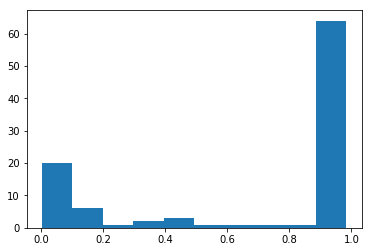

In [11]:
plt.hist(prediction[:,cat_n])

In [12]:
s0 = sample[0][prediction[:, cat_n]>0.5]
s1 = sample[1][prediction[:, cat_n]>0.5]
sample = (s0,s1)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0., 64.]),
 array([0.5808971 , 0.62122005, 0.661543  , 0.701866  , 0.74218893,
        0.78251183, 0.8228348 , 0.86315775, 0.9034807 , 0.94380367,
        0.9841266 ], dtype=float32),
 <a list of 10 Patch objects>)

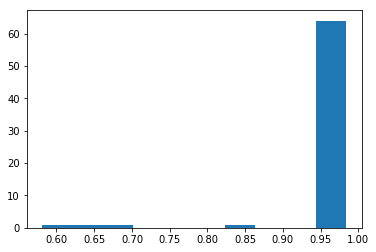

In [13]:
plt.hist(prediction[:,cat_n])

Show some instance

15
pdf


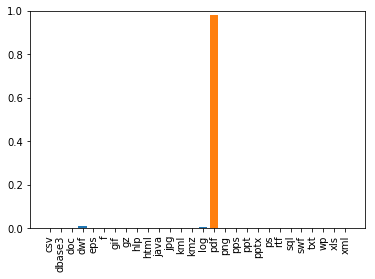

In [14]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 0)

15
pdf


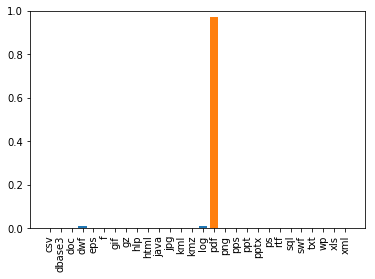

In [15]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 1)

15
pdf


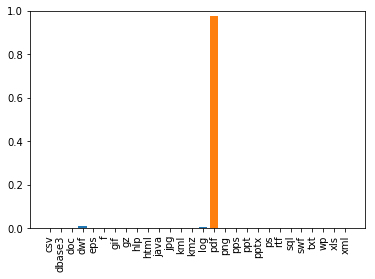

In [16]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 2)

15
pdf


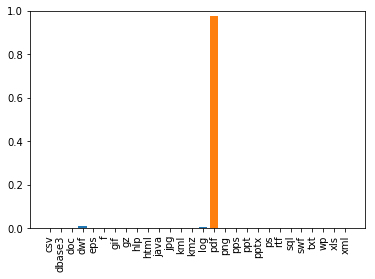

In [17]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 3)

#### Select the 'jpg' category

In [20]:
by_category = rawset.by_category()
batch_size = 100
cat = 'jpg'
cat_n = rawset.cat_to_ix[cat]
mycat = by_category[cat]
mycat.rebuild_categories(rawset.categories)
sampler = block_sampler.BlockSamplerFirstBlock(by_category[cat])
encoder = batch_encoder.BatchEncoder(sampler, batch_size=batch_size,xs_encoder='8bits_11')
itencoder = iter(encoder)

Pick a sample batch

In [21]:
sample = next(itencoder)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 3.,  1.,  3.,  0.,  2.,  1.,  0.,  3., 12., 75.]),
 array([2.1549514e-04, 9.9832065e-02, 1.9944865e-01, 2.9906520e-01,
        3.9868179e-01, 4.9829835e-01, 5.9791493e-01, 6.9753152e-01,
        7.9714805e-01, 8.9676464e-01, 9.9638122e-01], dtype=float32),
 <a list of 10 Patch objects>)

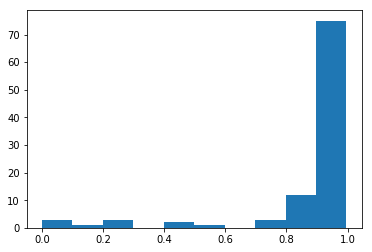

In [22]:
plt.hist(prediction[:,cat_n])

In [23]:
s0 = sample[0][prediction[:, cat_n]>0.5]
s1 = sample[1][prediction[:, cat_n]>0.5]
sample = (s0,s1)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 1.,  0.,  0.,  2.,  1.,  3.,  3.,  8., 53., 20.]),
 array([0.5855219 , 0.62660784, 0.66769373, 0.7087797 , 0.7498656 ,
        0.79095155, 0.8320375 , 0.8731234 , 0.91420937, 0.95529526,
        0.9963812 ], dtype=float32),
 <a list of 10 Patch objects>)

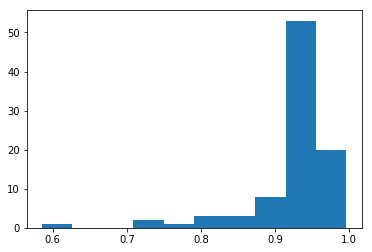

In [24]:
plt.hist(prediction[:,cat_n])

Show some instance

11
jpg


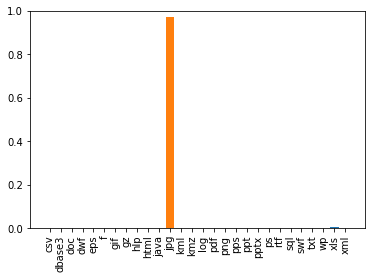

In [25]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 0)

11
jpg


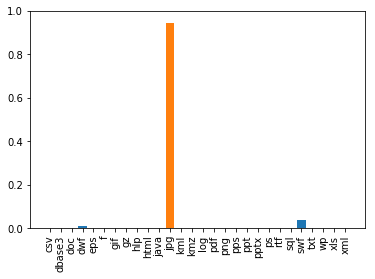

In [26]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 1)

11
jpg


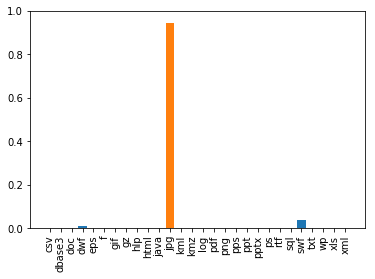

In [27]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 2)

11
jpg


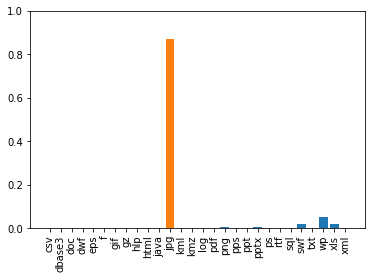

In [28]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 3)

# Train attention CAD

In [8]:
def mkmodel(classes, len_byte_vector, activation='softmax', loss='categorical_crossentropy'):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(32, (8,), strides=1, padding='same', activation='relu')(last)
    last = Attention(512, 32, name='attScores')(last)
    last = Dense(classes)(last)
    last = Activation(activation)(last)
    model = tensorflow.keras.Model(l0, last, name='attentionModel')
    model.compile(loss=loss,
        optimizer=tensorflow.keras.optimizers.Adam(),
        metrics=['categorical_accuracy', 'binary_accuracy'])
    return model

In [9]:
model = mkmodel(28, 8)

In [10]:
result = Trainer(model, blockSampler=BlockSamplerFirstBlock).train(*rawset.rnd_split_fraction_by_category(0.5))

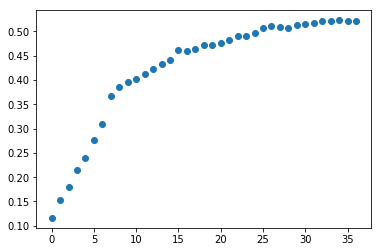

In [11]:
plt.plot(result.history.history['val_categorical_accuracy'], 'o')

In [12]:
result.model.save(result_dir + '/28classes-attention2.h5')

In [ ]:
r = report.Reporter2(result_dir + '/28classes-attention2.tsv')

r.line(name=result.model.name,
       elapsed=result.elapsed,
       **report.report_epochs(**result._asdict()),
       **report.report_metrics(result.history, result.metrics),
      )

r.close()

# Train attention 3

In [6]:
def mkmodel(classes, len_byte_vector, activation='softmax', loss='categorical_crossentropy'):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Flatten()(last)
    last = Dense(512, activation='sigmoid', name='attScores')(last)
    last = RepeatVector(8)(last)
    last = Permute([2,1])(last)
    last = Multiply(name='attVector')([last, l0])
    last = Flatten()(last)
    last = Dense(classes)(last)
    last = Activation(activation)(last)
    model = tensorflow.keras.Model(l0, last, name='attentionModel')
    model.compile(loss=loss,
        optimizer=tensorflow.keras.optimizers.Adam(),
        metrics=['categorical_accuracy', 'binary_accuracy'])
    return model

In [7]:
model = mkmodel(28, 8)
model.summary()

W0927 19:53:31.633918 140429217417024 deprecation.py:506] From /home/user/.local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "attentionModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 8)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 4096)         0           input_1[0][0]                    
__________________________________________________________________________________________________
attScores (Dense)               (None, 512)          2097664     flatten[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 8, 512)       0           attScores[0][0]                  
_____________________________________________________________________________________

In [8]:
result = Trainer(model, blockSampler=BlockSamplerFirstBlock).train(*rawset.rnd_split_fraction_by_category(0.5))

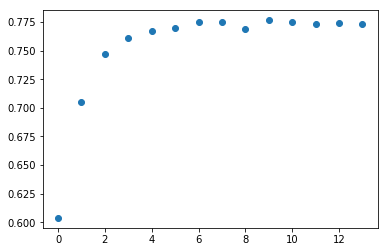

In [9]:
plt.plot(result.history.history['val_categorical_accuracy'], 'o')

In [10]:
result.model.save(result_dir + '/28classes-attention3.h5')

In [11]:
r = report.Reporter2(result_dir + '/28classes-attention3.tsv')

r.line(name=result.model.name,
       elapsed=result.elapsed,
       **report.report_epochs(**result._asdict()),
       **report.report_metrics(result.history, result.metrics),
      )

r.close()

# Load attention model

In [12]:
model = tensorflow.keras.models.load_model(result_dir + '/28classes-attention3.h5')

W0927 19:57:01.281090 140429217417024 deprecation.py:506] From /home/user/.local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0927 19:57:01.283105 140429217417024 deprecation.py:506] From /home/user/.local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
layer_name = 'attScores'
attention_layer_model = tensorflow.keras.Model(inputs=model.input,
                                               outputs=model.get_layer(layer_name).output)

In [15]:
pd.read_csv(result_dir + '/28classes-attention3.tsv', sep='\t')

,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,attentionModel,65.329098,14,0.984879,0.773375


## jpg

In [16]:
by_category = rawset.by_category()
batch_size = 100
cat = 'jpg'
cat_n = rawset.cat_to_ix[cat]
mycat = by_category[cat]
mycat.rebuild_categories(rawset.categories)
sampler = block_sampler.BlockSamplerFirstBlock(by_category[cat])
encoder = batch_encoder.BatchEncoder(sampler, batch_size=batch_size,xs_encoder='8bits_11')
itencoder = iter(encoder)

In [17]:
sample = next(itencoder)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  3.,  5., 90.]),
 array([0.00387775, 0.10348995, 0.20310216, 0.30271435, 0.40232655,
        0.50193876, 0.60155094, 0.7011632 , 0.80077535, 0.9003876 ,
        0.99999976], dtype=float32),
 <a list of 10 Patch objects>)

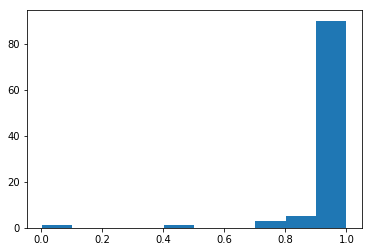

In [18]:
plt.hist(prediction[:,cat_n])

In [19]:
s0 = sample[0][prediction[:, cat_n]>0.5]
s1 = sample[1][prediction[:, cat_n]>0.5]
sample = (s0,s1)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 2.,  1.,  0.,  0.,  0.,  0.,  5.,  2.,  6., 82.]),
 array([0.7112892 , 0.7401603 , 0.76903135, 0.7979024 , 0.82677346,
        0.85564446, 0.8845155 , 0.9133866 , 0.94225764, 0.9711287 ,
        0.99999976], dtype=float32),
 <a list of 10 Patch objects>)

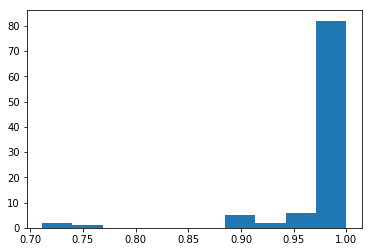

In [20]:
plt.hist(prediction[:,cat_n])

Show some instance

11
jpg


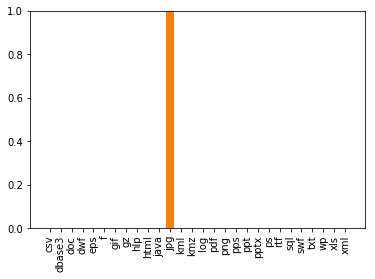

In [21]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 0)

11
jpg


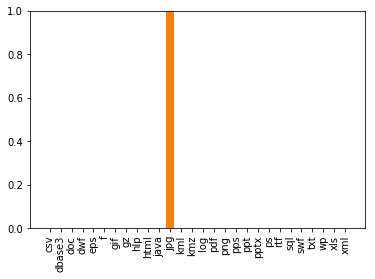

In [22]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 1)

11
jpg


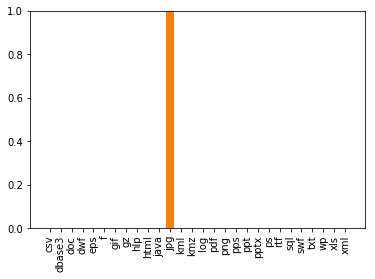

In [23]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 2)

11
jpg


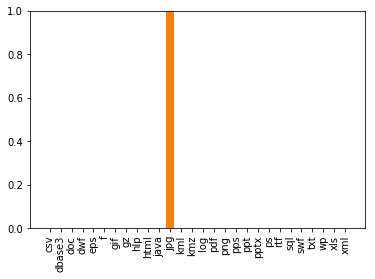

In [24]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 3)

# Train attention 4 - softmax

In [25]:
def mkmodel(classes, len_byte_vector, activation='softmax', loss='categorical_crossentropy'):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Flatten()(last)
    last = Dense(512, activation='softmax', name='attScores')(last)
    last = RepeatVector(8)(last)
    last = Permute([2,1])(last)
    last = Multiply(name='attVector')([last, l0])
    last = Flatten()(last)
    last = Dense(classes)(last)
    last = Activation(activation)(last)
    model = tensorflow.keras.Model(l0, last, name='attentionModel')
    model.compile(loss=loss,
        optimizer=tensorflow.keras.optimizers.Adam(),
        metrics=['categorical_accuracy', 'binary_accuracy'])
    return model

In [26]:
model = mkmodel(28, 8)
model.summary()

Model: "attentionModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 8)]     0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 4096)         0           input_2[0][0]                    
__________________________________________________________________________________________________
attScores (Dense)               (None, 512)          2097664     flatten_2[0][0]                  
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 8, 512)       0           attScores[0][0]                  
_____________________________________________________________________________________

In [27]:
result = Trainer(model, blockSampler=BlockSamplerFirstBlock).train(*rawset.rnd_split_fraction_by_category(0.5))

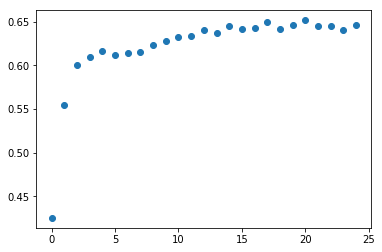

In [28]:
plt.plot(result.history.history['val_categorical_accuracy'], 'o')

In [29]:
result.model.save(result_dir + '/28classes-attention4.h5')

In [30]:
r = report.Reporter2(result_dir + '/28classes-attention4.tsv')

r.line(name=result.model.name,
       elapsed=result.elapsed,
       **report.report_epochs(**result._asdict()),
       **report.report_metrics(result.history, result.metrics),
      )

r.close()

# Load attention model

In [31]:
model = tensorflow.keras.models.load_model(result_dir + '/28classes-attention4.h5')

In [32]:
layer_name = 'attScores'
attention_layer_model = tensorflow.keras.Model(inputs=model.input,
                                               outputs=model.get_layer(layer_name).output)

In [33]:
pd.read_csv(result_dir + '/28classes-attention4.tsv', sep='\t')

,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,attentionModel,112.301436,25,0.974326,0.645875


## jpg

In [34]:
by_category = rawset.by_category()
batch_size = 100
cat = 'jpg'
cat_n = rawset.cat_to_ix[cat]
mycat = by_category[cat]
mycat.rebuild_categories(rawset.categories)
sampler = block_sampler.BlockSamplerFirstBlock(by_category[cat])
encoder = batch_encoder.BatchEncoder(sampler, batch_size=batch_size,xs_encoder='8bits_11')
itencoder = iter(encoder)

In [35]:
sample = next(itencoder)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 3.,  6., 15.,  8., 25., 12.,  0.,  5.,  0., 26.]),
 array([0.02588229, 0.07632568, 0.12676907, 0.17721245, 0.22765584,
        0.27809924, 0.32854262, 0.378986  , 0.42942938, 0.4798728 ,
        0.5303162 ], dtype=float32),
 <a list of 10 Patch objects>)

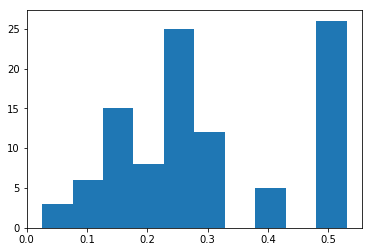

In [36]:
plt.hist(prediction[:,cat_n])

In [37]:
s0 = sample[0][prediction[:, cat_n]>0.5]
s1 = sample[1][prediction[:, cat_n]>0.5]
sample = (s0,s1)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 2.,  0.,  0.,  1.,  2.,  1.,  1.,  0.,  0., 19.]),
 array([0.5302944 , 0.53029656, 0.53029877, 0.530301  , 0.5303031 ,
        0.53030527, 0.5303075 , 0.5303097 , 0.5303118 , 0.53031397,
        0.5303162 ], dtype=float32),
 <a list of 10 Patch objects>)

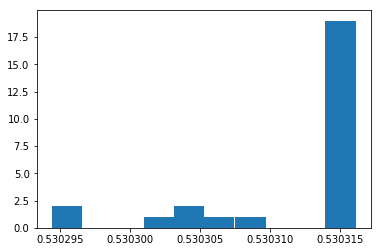

In [38]:
plt.hist(prediction[:,cat_n])

Show some instance

11
jpg


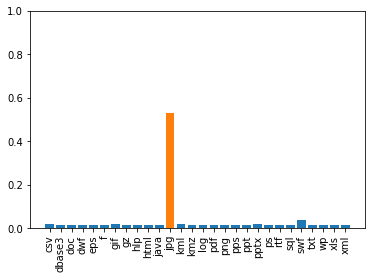

In [39]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 0)

11
jpg


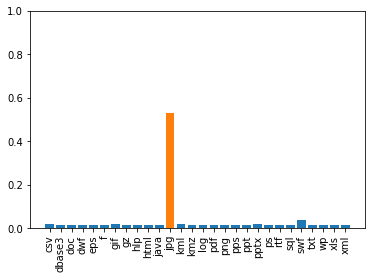

In [40]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 1)

11
jpg


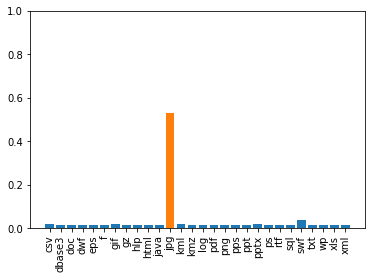

In [41]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 2)

11
jpg


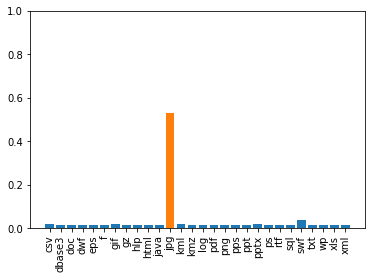

In [42]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 3)

# Train attention 5 - multilayer attention

In [134]:
def attentionModel(len_byte_vector, name='attentionModel'):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Flatten()(last)
    last = attScores = Dense(512, activation='sigmoid', name='attScores')(last)
    last = RepeatVector(8)(last)
    last = Permute([2,1])(last)
    last = Multiply(name='attVector')([last, l0])
    model = tensorflow.keras.Model(l0, last, name=name)
    return model
    
def mkmodel(classes, len_byte_vector, activation='softmax', loss='categorical_crossentropy'):
    last = l0 = Input(shape=(512,len_byte_vector))

    att = Flatten()(last)
    att = attScores = Dense(512, activation='relu', name='attScores1')(att)
    att = Activation('tanh')(att)
    att = RepeatVector(8)(att)
    att = Permute([2,1])(att)
    att = Multiply()([att, last])
    last = att1 = att

    att = Flatten()(last)
    att = attScores = Dense(512, activation='relu', name='attScores2')(att)
    att = Activation('tanh')(att)
    att = RepeatVector(8)(att)
    att = Permute([2,1])(att)
    att = Multiply()([att, last])
    last = att2 = att

    att = Flatten()(last)
    att = attScores = Dense(512, activation='relu', name='attScores3')(att)
    att = Activation('tanh')(att)
    att = RepeatVector(8)(att)
    att = Permute([2,1])(att)
    att = Multiply()([att, last])
    last = att3 = att

    last = Flatten()(last)
    last = Dense(classes)(last)
    last = Activation(activation)(last)
    model = tensorflow.keras.Model(l0, last, name='attentionModel')
    model.compile(loss=loss,
        optimizer=tensorflow.keras.optimizers.Adam(),
        metrics=['categorical_accuracy', 'binary_accuracy'])
    return model

In [135]:
model = mkmodel(28, 8)
model.summary()

Model: "attentionModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 512, 8)]     0                                            
__________________________________________________________________________________________________
flatten_40 (Flatten)            (None, 4096)         0           input_28[0][0]                   
__________________________________________________________________________________________________
attScores1 (Dense)              (None, 512)          2097664     flatten_40[0][0]                 
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 512)          0           attScores1[0][0]                 
_____________________________________________________________________________________

In [136]:
result = Trainer(model, blockSampler=BlockSamplerFirstBlock, patience=1).train(*rawset.rnd_split_fraction_by_category(0.5))

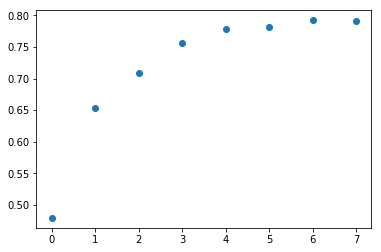

In [137]:
plt.plot(result.history.history['val_categorical_accuracy'], 'o')

In [138]:
result.model.save(result_dir + '/28classes-attention5.h5')

In [139]:
r = report.Reporter2(result_dir + '/28classes-attention5.tsv')

r.line(name=result.model.name,
       elapsed=result.elapsed,
       **report.report_epochs(**result._asdict()),
       **report.report_metrics(result.history, result.metrics),
      )

r.close()

# Load attention model

In [140]:
model = tensorflow.keras.models.load_model(result_dir + '/28classes-attention5.h5')

In [141]:
layer_name = 'attScores3'
attention_layer_model = tensorflow.keras.Model(inputs=model.input,
                                               outputs=model.get_layer(layer_name).output)

In [142]:
pd.read_csv(result_dir + '/28classes-attention5.tsv', sep='\t')

,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,attentionModel,157.69088578224182,19,0.9859331,0.8045
1,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
2,attentionModel,37.834348917007446,5,0.9855133,0.790625
3,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
4,attentionModel,52.63366770744324,7,0.9849465,0.78875
5,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
6,attentionModel,30.666011333465576,4,0.9877007,0.808
7,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
8,attentionModel,18.81269359588623,2,0.94936144,0.139875
9,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy


## jpg

In [143]:
by_category = rawset.by_category()
batch_size = 100
cat = 'jpg'
cat_n = rawset.cat_to_ix[cat]
mycat = by_category[cat]
mycat.rebuild_categories(rawset.categories)
sampler = block_sampler.BlockSamplerFirstBlock(by_category[cat])
encoder = batch_encoder.BatchEncoder(sampler, batch_size=batch_size,xs_encoder='8bits_11')
itencoder = iter(encoder)

In [144]:
sample = next(itencoder)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  4., 93.]),
 array([0.07170189, 0.164531  , 0.25736013, 0.35018924, 0.44301838,
        0.5358475 , 0.6286766 , 0.7215057 , 0.81433487, 0.907164  ,
        0.9999931 ], dtype=float32),
 <a list of 10 Patch objects>)

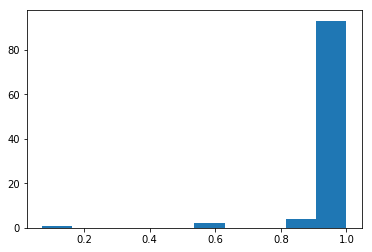

In [145]:
plt.hist(prediction[:,cat_n])

In [146]:
s0 = sample[0][prediction[:, cat_n]>0.5]
s1 = sample[1][prediction[:, cat_n]>0.5]
sample = (s0,s1)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 2.,  0.,  0.,  0.,  0.,  0.,  1.,  4.,  3., 89.]),
 array([0.6117907 , 0.6506109 , 0.6894312 , 0.72825146, 0.76707166,
        0.8058919 , 0.84471214, 0.8835324 , 0.9223526 , 0.9611728 ,
        0.9999931 ], dtype=float32),
 <a list of 10 Patch objects>)

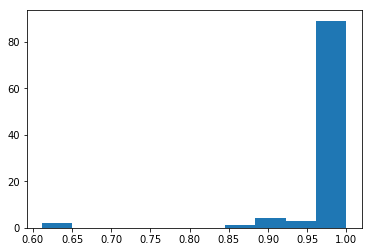

In [147]:
plt.hist(prediction[:,cat_n])

Show some instance

11
jpg


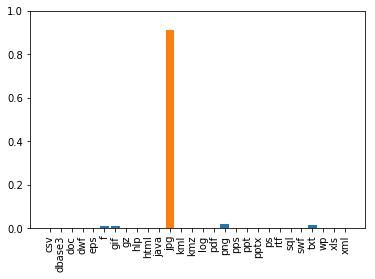

In [148]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 0)

11
jpg


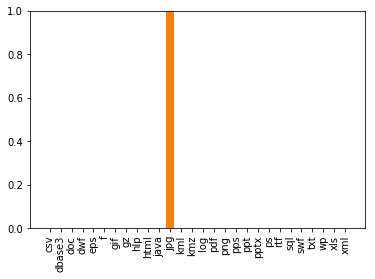

In [149]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 1)

11
jpg


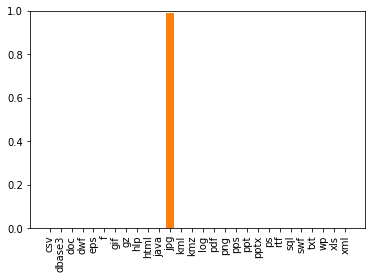

In [150]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 2)

11
jpg


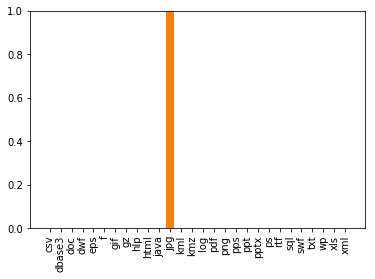

In [151]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 3)

# Train attention 6 - multilayer attention with conv

In [78]:
def scale_avg(att):
    w = K.sum(att, axis=1)
    w = K.repeat_elements(w, 253, 1)
    w = K.squeeze(att, 2)/w
    return att

def mkmodel(classes, len_byte_vector, activation='softmax', loss='categorical_crossentropy'):
    last = l0 = Input(shape=(512,len_byte_vector))

    window = 8
    strides = 2
    att = Conv1D(1, (window,), strides=strides)(last)
    att = Activation('relu')(att)
    att = Activation('tanh')(att)
#     att = BatchNormalization(axis=1)(att)
    att = Lambda(scale_avg)(att)
    mask = np.zeros((att.shape[1],512))
    for x in range(mask.shape[0]):
        mask[x,x*strides:x*strides+window]=1
    mask = mask.reshape((1,*mask.shape))
    mask = tf.convert_to_tensor(mask, dtype='float32')
    att = Dot([1,1])([att,mask])
    att = Reshape((512,))(att)    
    att = RepeatVector(8)(att)
    att = Permute([2,1])(att)
    att = Multiply()([att, last])
    last = att1 = att

#     last = Conv1D(1, (window,), strides=strides)(last)
    last = Flatten()(last)
    last = Dense(classes)(last)
    last = Activation(activation)(last)
    model = tensorflow.keras.Model(l0, last, name='attentionModel')
    model.compile(loss=loss,
        optimizer=tensorflow.keras.optimizers.Adam(),
        metrics=['categorical_accuracy', 'binary_accuracy'])
    return model

In [24]:
model = mkmodel(28, 8)
model.summary()

Model: "attentionModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 512, 8)]     0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 253, 1)       65          input_5[0][0]                    
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 253, 1)       0           conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 253, 1)       0           activation_11[0][0]              
_____________________________________________________________________________________

In [25]:
result = Trainer(model, blockSampler=BlockSamplerFirstBlock, patience=1).train(*rawset.rnd_split_fraction_by_category(0.5))

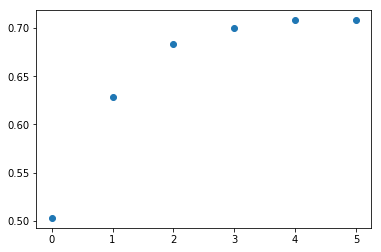

In [26]:
plt.plot(result.history.history['val_categorical_accuracy'], 'o')

In [ ]:
result.model.save(result_dir + '/28classes-attention6.h5')

In [28]:
r = report.Reporter2(result_dir + '/28classes-attention6.tsv')

r.line(name=result.model.name,
       elapsed=result.elapsed,
       **report.report_epochs(**result._asdict()),
       **report.report_metrics(result.history, result.metrics),
      )

r.close()

# Load attention model

In [ ]:
model = tensorflow.keras.models.load_model(result_dir + '/28classes-attention6.h5')

In [30]:
layer_name = 'reshape_5'
attention_layer_model = tensorflow.keras.Model(inputs=model.input,
                                               outputs=model.get_layer(layer_name).output)

In [31]:
pd.read_csv(result_dir + '/28classes-attention6.tsv', sep='\t')

,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,attentionModel,100.96041703224182,20,0.9690403,0.719875
1,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
2,attentionModel,34.53078556060791,6,0.96428585,0.207125
3,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
4,attentionModel,89.36383175849915,19,0.9689376,0.71675
5,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
6,attentionModel,79.71731448173523,17,0.96839744,0.702125
7,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
8,attentionModel,81.23623251914978,18,0.97762495,0.6225
9,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy


## jpg

In [32]:
by_category = rawset.by_category()
batch_size = 100
cat = 'jpg'
cat_n = rawset.cat_to_ix[cat]
mycat = by_category[cat]
mycat.rebuild_categories(rawset.categories)
sampler = block_sampler.BlockSamplerFirstBlock(by_category[cat])
encoder = batch_encoder.BatchEncoder(sampler, batch_size=batch_size,xs_encoder='8bits_11')
itencoder = iter(encoder)

In [53]:
sample = next(itencoder)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 3.,  0.,  2.,  1.,  0.,  2.,  1.,  0.,  1., 90.]),
 array([3.0575081e-06, 1.0000275e-01, 2.0000245e-01, 3.0000213e-01,
        4.0000182e-01, 5.0000155e-01, 6.0000122e-01, 7.0000094e-01,
        8.0000061e-01, 9.0000033e-01, 1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

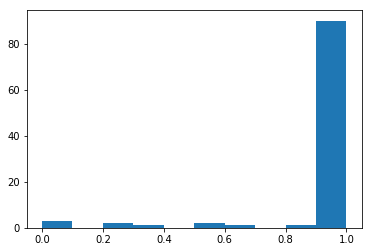

In [54]:
plt.hist(prediction[:,cat_n])

In [55]:
s0 = sample[0][prediction[:, cat_n]>0.6]
s1 = sample[1][prediction[:, cat_n]>0.6]
sample = (s0,s1)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  2., 87.]),
 array([0.6636036 , 0.6972432 , 0.7308829 , 0.76452255, 0.79816216,
        0.8318018 , 0.86544144, 0.8990811 , 0.9327207 , 0.96636033,
        1.        ], dtype=float32),
 <a list of 10 Patch objects>)

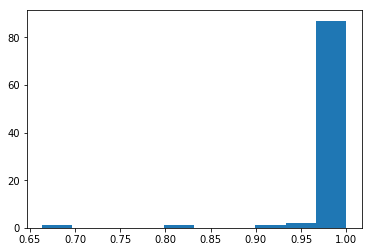

In [56]:
plt.hist(prediction[:,cat_n])

Show some instance

11
jpg


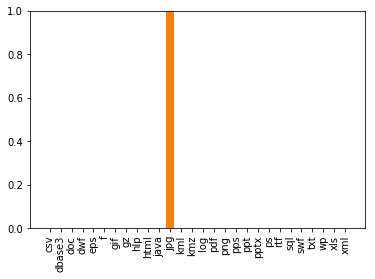

In [57]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 0)

11
jpg


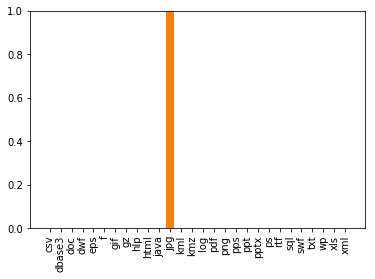

In [58]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 1)

11
jpg


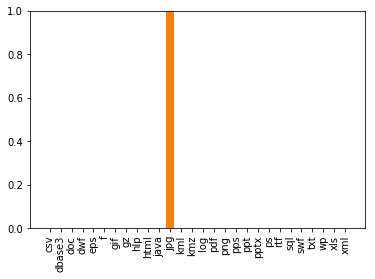

In [59]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 2)

11
jpg


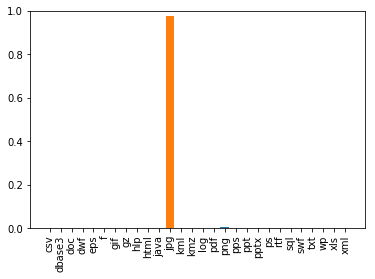

In [60]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 3)

# Train attention 7 - multilayer attention with conv

In [61]:
def mkmodel(classes, len_byte_vector, activation='softmax', loss='categorical_crossentropy'):
    last = l0 = Input(shape=(512,len_byte_vector))

    window = 8
    strides = 2
    att = Conv1D(1, (window,), strides=strides)(last)
    att = Activation('relu')(att)
    att = Activation('tanh')(att)
    att = BatchNormalization(axis=1)(att)
    mask = np.zeros((att.shape[1],512))
    for x in range(mask.shape[0]):
        mask[x,x*strides:x*strides+window]=1
    mask = mask.reshape((1,*mask.shape))
    mask = tf.convert_to_tensor(mask, dtype='float32')
    att = Dot([1,1])([att,mask])
    att = Reshape((512,))(att)    
    att = RepeatVector(8)(att)
    att = Permute([2,1])(att)
    att = Multiply()([att, last])
    last = att1 = att

#     last = Conv1D(1, (window,), strides=strides)(last)
    last = Flatten()(last)
    last = Dense(classes)(last)
    last = Activation(activation)(last)
    model = tensorflow.keras.Model(l0, last, name='attentionModel')
    model.compile(loss=loss,
        optimizer=tensorflow.keras.optimizers.Adam(),
        metrics=['categorical_accuracy', 'binary_accuracy'])
    return model

In [62]:
model = mkmodel(28, 8)
model.summary()

Model: "attentionModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512, 8)]     0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 253, 1)       65          input_6[0][0]                    
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 253, 1)       0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 253, 1)       0           activation_14[0][0]              
_____________________________________________________________________________________

In [63]:
result = Trainer(model, blockSampler=BlockSamplerFirstBlock, patience=1).train(*rawset.rnd_split_fraction_by_category(0.5))

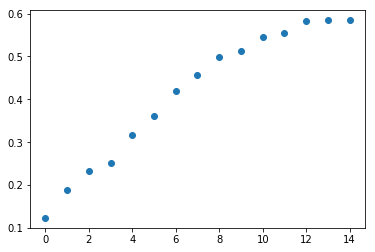

In [64]:
plt.plot(result.history.history['val_categorical_accuracy'], 'o')

In [ ]:
result.model.save(result_dir + '/28classes-attention7.h5')

In [66]:
r = report.Reporter2(result_dir + '/28classes-attention7.tsv')

r.line(name=result.model.name,
       elapsed=result.elapsed,
       **report.report_epochs(**result._asdict()),
       **report.report_metrics(result.history, result.metrics),
      )

r.close()

# Load attention model

In [ ]:
model = tensorflow.keras.models.load_model(result_dir + '/28classes-attention7.h5')

In [67]:
layer_name = 'reshape_6'
attention_layer_model = tensorflow.keras.Model(inputs=model.input,
                                               outputs=model.get_layer(layer_name).output)

In [68]:
pd.read_csv(result_dir + '/28classes-attention7.tsv', sep='\t')

,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,attentionModel,67.744153,15,0.976634,0.58425


## jpg

In [69]:
by_category = rawset.by_category()
batch_size = 100
cat = 'jpg'
cat_n = rawset.cat_to_ix[cat]
mycat = by_category[cat]
mycat.rebuild_categories(rawset.categories)
sampler = block_sampler.BlockSamplerFirstBlock(by_category[cat])
encoder = batch_encoder.BatchEncoder(sampler, batch_size=batch_size,xs_encoder='8bits_11')
itencoder = iter(encoder)

In [70]:
sample = next(itencoder)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 8.,  6.,  4.,  4., 13.,  6.,  7.,  2., 13., 37.]),
 array([0.01400753, 0.11255722, 0.21110691, 0.30965662, 0.4082063 ,
        0.506756  , 0.6053057 , 0.7038554 , 0.80240506, 0.9009548 ,
        0.99950445], dtype=float32),
 <a list of 10 Patch objects>)

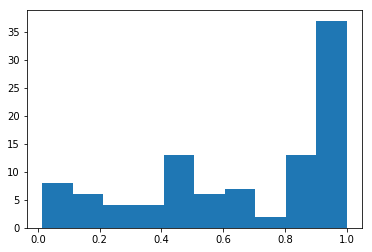

In [71]:
plt.hist(prediction[:,cat_n])

In [72]:
s0 = sample[0][prediction[:, cat_n]>0.6]
s1 = sample[1][prediction[:, cat_n]>0.6]
sample = (s0,s1)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 4.,  3.,  0.,  2.,  0.,  5.,  5.,  5.,  8., 27.]),
 array([0.6083756 , 0.6474885 , 0.6866014 , 0.72571427, 0.76482713,
        0.80394006, 0.8430529 , 0.8821658 , 0.92127866, 0.9603916 ,
        0.99950445], dtype=float32),
 <a list of 10 Patch objects>)

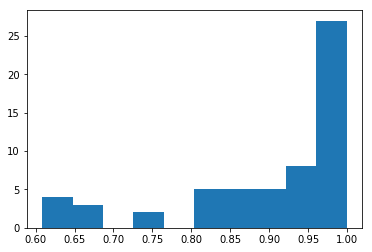

In [73]:
plt.hist(prediction[:,cat_n])

Show some instance

11
jpg


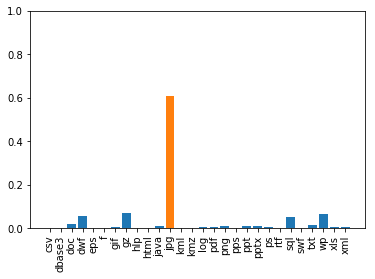

In [74]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 0)

11
jpg


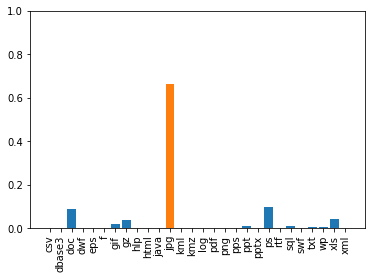

In [75]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 1)

11
jpg


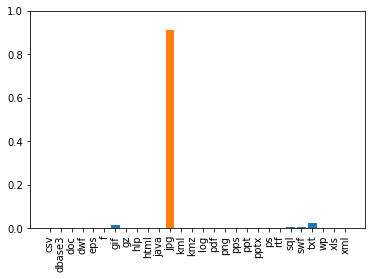

In [76]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 2)

11
jpg


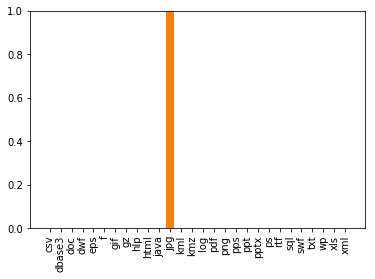

In [77]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 3)

# Train attention 8 - multilayer attention with conv

In [103]:
def scale_avg(att):
    w = K.sum(att, axis=1)
    w = K.repeat_elements(w, 253, 1)
    w = K.squeeze(att, 2)/w
    return att

def mkmodel(classes, len_byte_vector, activation='softmax', loss='categorical_crossentropy'):
    last = l0 = Input(shape=(512,len_byte_vector))

    window = 8
    strides = 2
    att = last
    att = Conv1D(1024, (window,), strides=strides, activation='relu')(att)
    att = Conv1D(1, (1,), strides=1, activation='relu')(att)
    att = Activation('tanh')(att)
#     att = BatchNormalization(axis=1)(att)
    att = Lambda(scale_avg)(att)
    mask = np.zeros((att.shape[1],512))
    for x in range(mask.shape[0]):
        mask[x,x*strides:x*strides+window]=1
    mask = mask.reshape((1,*mask.shape))
    mask = tf.convert_to_tensor(mask, dtype='float32')
    att = Dot([1,1])([att,mask])
    att = Reshape((512,))(att)    
    att = RepeatVector(8)(att)
    att = Permute([2,1])(att)
    att = Multiply()([att, last])
    last = att1 = att

#     last = Conv1D(1, (window,), strides=strides)(last)
    last = Flatten()(last)
    last = Dense(classes)(last)
    last = Activation(activation)(last)
    model = tensorflow.keras.Model(l0, last, name='attentionModel')
    model.compile(loss=loss,
        optimizer=tensorflow.keras.optimizers.Adam(),
        metrics=['categorical_accuracy', 'binary_accuracy'])
    return model

In [104]:
model = mkmodel(28, 8)
model.summary()

Model: "attentionModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 512, 8)]     0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 253, 1024)    66560       input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 253, 1)       1025        conv1d_14[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 253, 1)       0           conv1d_15[0][0]                  
_____________________________________________________________________________________

In [105]:
result = Trainer(model, blockSampler=BlockSamplerFirstBlock, patience=1).train(*rawset.rnd_split_fraction_by_category(0.5))

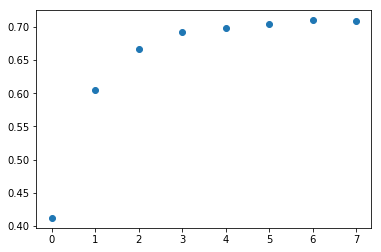

In [106]:
plt.plot(result.history.history['val_categorical_accuracy'], 'o')

In [ ]:
result.model.save(result_dir + '/28classes-attention8.h5')

In [89]:
r = report.Reporter2(result_dir + '/28classes-attention8.tsv')

r.line(name=result.model.name,
       elapsed=result.elapsed,
       **report.report_epochs(**result._asdict()),
       **report.report_metrics(result.history, result.metrics),
      )

r.close()

# Load attention model

In [ ]:
model = tensorflow.keras.models.load_model(result_dir + '/28classes-attention8.h5')

In [92]:
layer_name = 'reshape_10'
attention_layer_model = tensorflow.keras.Model(inputs=model.input,
                                               outputs=model.get_layer(layer_name).output)

In [93]:
pd.read_csv(result_dir + '/28classes-attention8.tsv', sep='\t')

,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,attentionModel,162.49866,7,0.981482,0.6935


## jpg

In [94]:
by_category = rawset.by_category()
batch_size = 100
cat = 'jpg'
cat_n = rawset.cat_to_ix[cat]
mycat = by_category[cat]
mycat.rebuild_categories(rawset.categories)
sampler = block_sampler.BlockSamplerFirstBlock(by_category[cat])
encoder = batch_encoder.BatchEncoder(sampler, batch_size=batch_size,xs_encoder='8bits_11')
itencoder = iter(encoder)

In [95]:
sample = next(itencoder)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0., 97.]),
 array([2.8625593e-04, 1.0025763e-01, 2.0022900e-01, 3.0020037e-01,
        4.0017176e-01, 5.0014311e-01, 6.0011452e-01, 7.0008588e-01,
        8.0005723e-01, 9.0002865e-01, 1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

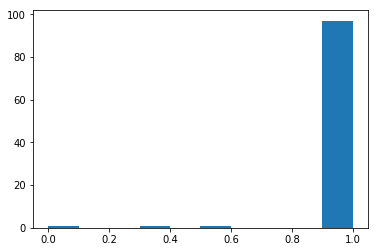

In [96]:
plt.hist(prediction[:,cat_n])

In [97]:
s0 = sample[0][prediction[:, cat_n]>0.6]
s1 = sample[1][prediction[:, cat_n]>0.6]
sample = (s0,s1)
attention_output = attention_layer_model.predict(sample)
prediction = model.predict(sample)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  3., 91.]),
 array([0.9272733 , 0.93454593, 0.9418186 , 0.9490913 , 0.956364  ,
        0.96363664, 0.9709093 , 0.97818196, 0.9854547 , 0.99272734,
        1.        ], dtype=float32),
 <a list of 10 Patch objects>)

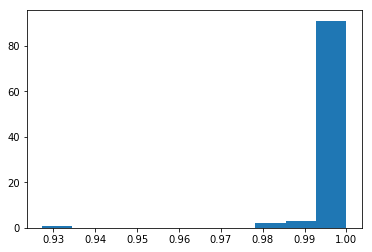

In [98]:
plt.hist(prediction[:,cat_n])

Show some instance

11
jpg


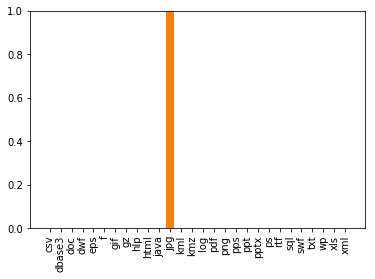

In [99]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 0)

11
jpg


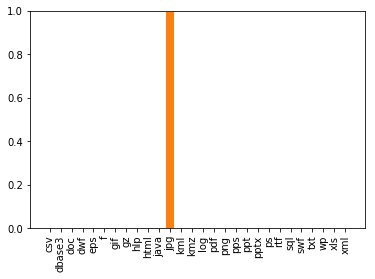

In [100]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 1)

11
jpg


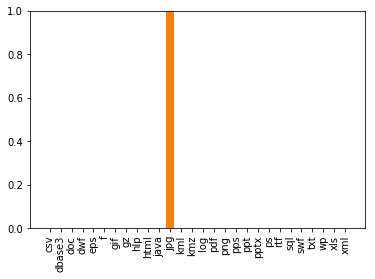

In [101]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 2)

11
jpg


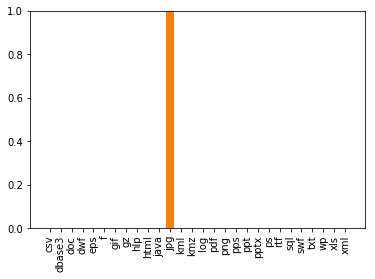

In [102]:
showSample(sample,model,attention_layer_model, rawset.ix_to_cat, 3)